In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
data_file = 'arrhythmia.data'
df = pd.read_csv(data_file, header=None)

In [3]:
# classes_to_drop = [7, 8, 14, 15]  
# mask = ~df.iloc[:,-1].isin(classes_to_drop)
# filtered_df = df[mask]
# print(filtered_df.shape)

In [4]:
## replicating data points with 5 or fewer samples  
from collections import Counter
class_counts = Counter(df.iloc[:,-1])   # counting class labels 
classes_to_augment = [class_label for class_label, count,  in class_counts.items() if count<6] # identify class labels to replicate 
# loop over classes to replicate
for class_label in classes_to_augment:
    class_rows = df[df.iloc[:,-1]==class_label]
     # replicate the rows until the class count reaches at least 6
    while class_counts[class_label]<6:
        df = pd.concat([df, class_rows], ignore_index=True)
        class_counts[class_label] += len(class_rows)
class_counts = Counter(df.iloc[:,-1])
for class_label, count in class_counts.items():
    print(f" Class {class_label} has {count}")

 Class 8 has 6
 Class 6 has 25
 Class 10 has 50
 Class 1 has 245
 Class 7 has 6
 Class 14 has 8
 Class 3 has 15
 Class 16 has 22
 Class 2 has 44
 Class 4 has 15
 Class 5 has 13
 Class 9 has 9
 Class 15 has 10


In [5]:

# handling missing values 
from sklearn.impute import SimpleImputer
df.replace("?", np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_data = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed_data, columns=df.columns)
print(df_imputed.shape)

(468, 280)


In [6]:
# nominal = [1, 21, 22, 23, 24, 25, 26, 33, 34, 35, 36, 37, 38, 45, 46, 47, 48, 49, 50, 57, 58, 59, 60, 61, 62, 69, 70, 71, 72, 73, 74, 81, 82, 83, 84, 85, 86, 93, 94, 95, 96, 97, 98, 105, 106, 107, 108, 109, 110, 117, 118, 119, 120, 121, 122, 129, 130, 131, 132, 133, 134, 141, 142, 143, 144, 145, 146, 153, 154, 155, 156, 157, 158]
# 
# df_imputed.drop(df_imputed.columns[nominal], axis=1, inplace=True)
# print(df_imputed.shape)

In [7]:
X = df_imputed.iloc[ :,:-1].values
y=df_imputed.iloc[:,-1]
print(np.shape(X))
print(np.shape(y))

(468, 279)
(468,)


In [8]:
# apply Synthetic Minority Oversampling Technique(SMOTE):

from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE(random_state=0).fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)

(3185, 279)
(3185,)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()

# features scaling 
X_scaled = sc.fit_transform(X_res)
pca = PCA()
pca.fit(X_scaled)
pca_data = pca.transform(X_scaled)

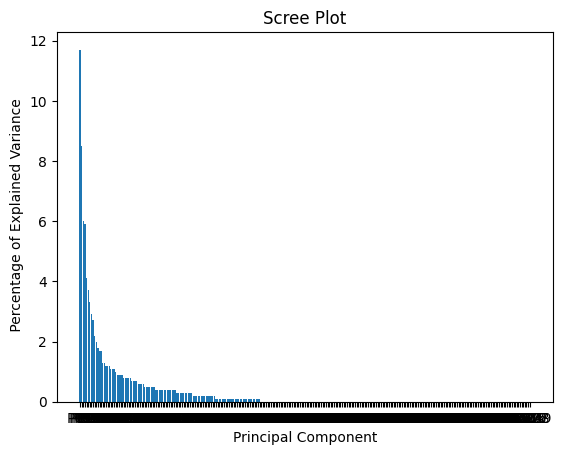

In [10]:
# compute the percentage of explained variance for each principal component
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

# create labels for the principal components 
labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]

# plotting 
plt.bar(x=range(1,len(per_var) + 1), height=per_var, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel(' Percentage of Explained Variance')
plt.title('Scree Plot')
plt.show()

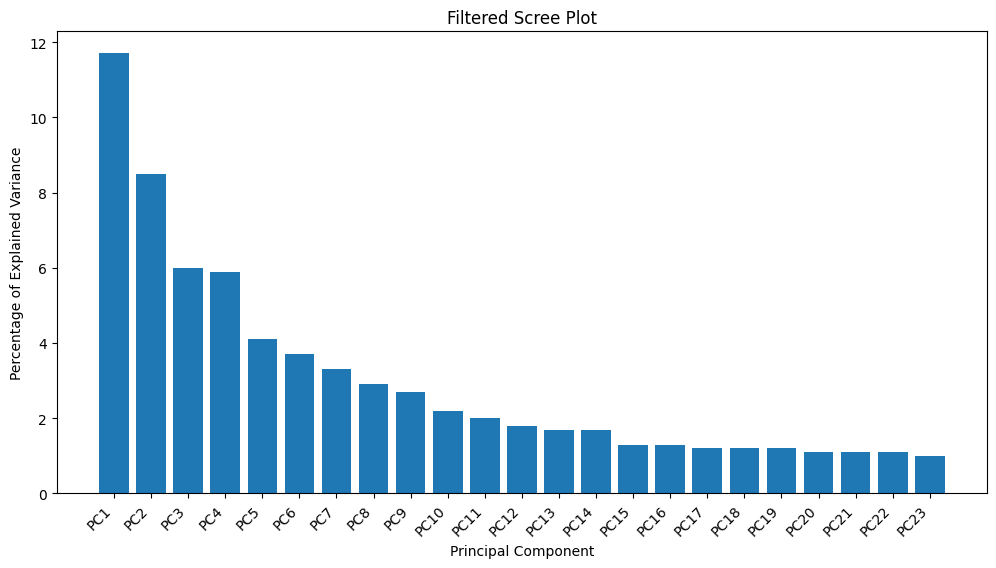

In [11]:
threshold = 1   # threshold for selecting important component 1% 

important_components = per_var[per_var >= threshold]    # select the components with explained variance greater than or equal to the threshold

# plotting 
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x=range(1, len(important_components) + 1), height=important_components, tick_label=labels[:len(important_components)])
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Filtered Scree Plot')
plt.xticks(rotation=45, ha='right')
plt.show()


In [12]:
important_indices = [i for i, variance in enumerate(per_var) if variance >= threshold]
important_pca_data = pca_data[:, important_indices]
print(important_pca_data.shape)

(3185, 23)


In [13]:
new_X = pd.DataFrame(important_pca_data)
print(new_X.shape)
print(y_res.shape)

(3185, 23)
(3185,)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(new_X, y_res, test_size=0.2, random_state=42)

classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)
# Predictions and evaluation
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9199372056514914
Classification Report:
               precision    recall  f1-score   support

         1.0       0.73      0.50      0.59        60
         2.0       0.89      0.93      0.91        55
         3.0       1.00      1.00      1.00        48
         4.0       0.98      1.00      0.99        53
         5.0       0.93      1.00      0.96        50
         6.0       0.77      0.92      0.84        51
         7.0       1.00      1.00      1.00        50
         8.0       1.00      1.00      1.00        44
         9.0       1.00      1.00      1.00        44
        10.0       0.92      0.90      0.91        50
        14.0       1.00      1.00      1.00        40
        15.0       1.00      1.00      1.00        44
        16.0       0.78      0.83      0.81        48

    accuracy                           0.92       637
   macro avg       0.92      0.93      0.92       637
weighted avg       0.92      0.92      0.92       637



In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    columns = [f'Pred:{label}' for label in labels ]
    index = [f'True{label}' for label in labels ]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table

plot(y_pred, y_test)

,Pred:1.0,Pred:2.0,Pred:3.0,Pred:4.0,Pred:5.0,Pred:6.0,Pred:7.0,Pred:8.0,Pred:9.0,Pred:10.0,Pred:14.0,Pred:15.0,Pred:16.0
True1.0,30,2,0,0,0,2,0,0,0,3,0,0,4
True2.0,5,51,0,0,0,0,0,0,0,0,0,0,1
True3.0,0,0,48,0,0,0,0,0,0,0,0,0,0
True4.0,0,1,0,53,0,0,0,0,0,0,0,0,0
True5.0,2,0,0,0,50,0,0,0,0,1,0,0,1
True6.0,12,1,0,0,0,47,0,0,0,1,0,0,0
True7.0,0,0,0,0,0,0,50,0,0,0,0,0,0
True8.0,0,0,0,0,0,0,0,44,0,0,0,0,0
True9.0,0,0,0,0,0,0,0,0,44,0,0,0,0
True10.0,2,0,0,0,0,0,0,0,0,45,0,0,2


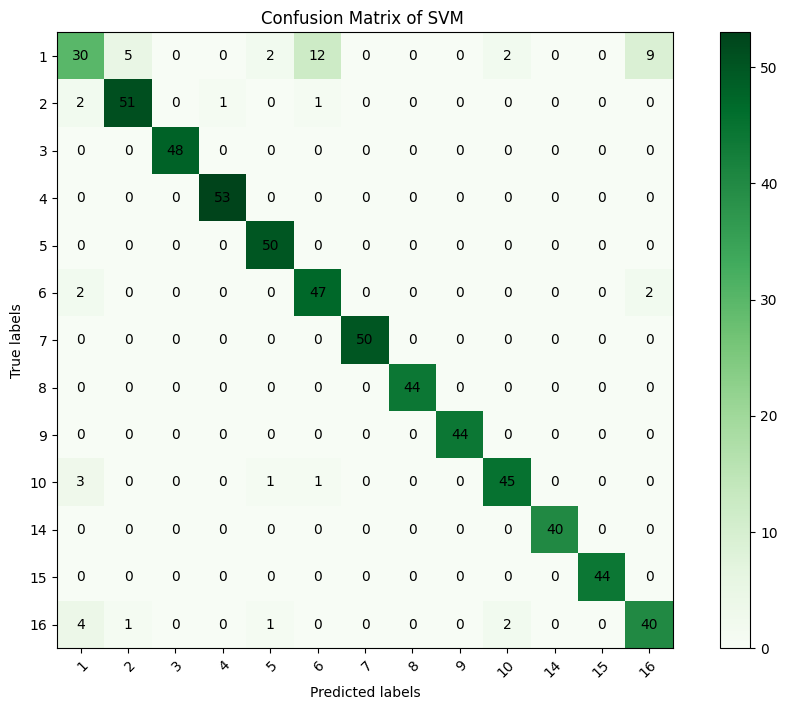

In [16]:
from sklearn.metrics import confusion_matrix

# define the labels for the confusion matrix
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16]

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# plotting 
plt.figure(figsize=(12, 8))
ax = plt.gca()

# create a heatmap of the confusion matrix
cax = ax.imshow(cm, interpolation='nearest', cmap='Greens')
plt.colorbar(cax)  

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of SVM ')
ax.grid(False)  

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

plt.show()


In [17]:
print(cm)

[[30  5  0  0  2 12  0  0  0  2  0  0  9]
 [ 2 51  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 53  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0 47  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0  0  0]
 [ 3  0  0  0  1  1  0  0  0 45  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 44  0]
 [ 4  1  0  0  1  0  0  0  0  2  0  0 40]]
